# Entropy and SVM Anomaly Detection

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import UgrUtils as utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

from scipy.stats import entropy

In [34]:
# experiment parameters
timeWindow = 30 * 60 # 30 minutes

In [4]:
# read data
df = pd.read_csv("dataset/2016-06-20_SMTP_100.csv")

In [98]:
df = utils.addTimebin(df, timeWindow)
df.head()

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,type,timebin
0,2016-06-20 00:07:11,3.324,42.219.145.241,79.28.21.23,25,60052,TCP,.AP.SF,0,0,29,2172,background,814640
1,2016-06-20 00:07:14,1.960,42.219.156.185,108.66.255.250,54726,25,TCP,.APRS.,0,0,10,827,background,814640
2,2016-06-20 00:07:24,0.172,42.91.149.234,42.219.159.90,587,23821,TCP,.AP.S.,0,0,4,342,background,814640
3,2016-06-20 00:07:29,0.812,42.219.156.183,187.35.0.150,48946,25,TCP,.APRS.,0,0,8,515,background,814640
4,2016-06-20 00:07:30,1.024,42.219.158.179,56.10.179.181,25,61138,TCP,.AP.SF,0,0,8,657,background,814640


In [20]:
def ent(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    H=entropy(p_data)  # input probabilities to get the entropy 
    return H

In [30]:
def agg(df, features):
    '''
    returns list of entropies of supplied features
    '''
    return [ent(df[feature]) for feature in features]

In [99]:
def aggGroups(dfGroups):
    features = ['sa', 'da', 'sp', 'dp' , 'flg', 'byt']
    data = [[utils.timeBinToDate(l, timeWindow)] + agg(df, features) for l, df in dfGroups]
    columns = ['time'] + ['H({})'.format(f) for f in features]
    return pd.DataFrame(data, columns = columns)

In [102]:
# test
df_agg = aggGroups(df.groupby('timebin'))
df_agg.head()
df_agg.to_csv("temp.csv")

## Anomaly Utils

In [32]:
def timebinAnom(df, anoms):
    # warning, first column of csv has to be changed to 'te' for convenience
    df = utils.addTimebin(df, timeWindow)
    filteredCols = ['timebin'] + anoms
    df = df[filteredCols]
    df_agg = df.groupby('timebin').agg(sum)
    df_agg['time'] = df_agg.apply(lambda row : utils.timeBinToDate(row.name, timeWindow), axis = 1)
    filteredCols = ['time'] + anoms
    print(filteredCols)
    df_agg = df_agg.reset_index()
    df_agg = df_agg[filteredCols]
    return df_agg

In [89]:
anoms = ["anomaly-spam"]
df_anom = pd.read_csv("dataset/attack_ts_june_week4.csv")
df_anom = timebinAnom(df_anom, anoms)
df_anom['time'] = pd.to_datetime(df_anom['time'])
df_anom.tail()

['time', 'anomaly-spam']


,time,anomaly-spam
320,2016-06-26 16:00:00,30
321,2016-06-26 16:30:00,30
322,2016-06-26 17:00:00,30
323,2016-06-26 17:30:00,21
324,2016-06-26 18:00:00,0


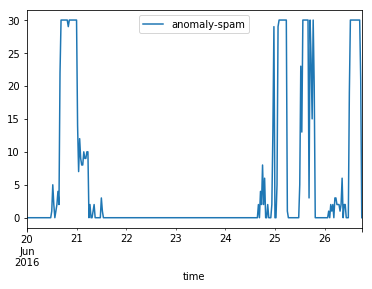

In [90]:
df_anom.plot(x='time', y = anoms)

In [97]:
Y_spam = [0] * len(df_anom) 
X_spam = list(df_anom['time'])
size_spam = list(df_anom['anomaly-spam'])

## Entropy Stuff

In [98]:
# merge all csvs
df1 = pd.read_csv("experiment 1/2016-06-20_agg.csv")
df2 = pd.read_csv("experiment 1/2016-06-21_agg.csv")
df3 = pd.read_csv("experiment 1/2016-06-22_agg.csv")
dfs = [df1, df2, df3]

df_agg = pd.concat(dfs, ignore_index=True)
df_agg['time'] = pd.to_datetime(df_agg['time'])
# from functools import reduce
# df_agg = reduce(lambda left, right : pd.append(left, right), dfs) 

In [99]:
df_agg.head()

,time,H(sa),H(da),H(sp),H(dp),H(flg),H(byt),Flows,Bytes
0,2016-06-20 00:00:00,4.786381,4.849955,5.581641,5.077501,1.759142,5.312246,45668,654268794
1,2016-06-20 00:30:00,3.864454,3.917633,5.770387,5.466342,1.487525,3.920452,119540,1068343656
2,2016-06-20 01:00:00,4.833561,4.919651,5.647410,5.081787,1.713910,5.359955,56340,717709088
3,2016-06-20 01:30:00,3.027618,3.058674,5.850479,5.640562,1.299512,3.171449,222962,719840124
4,2016-06-20 02:00:00,4.701964,4.778389,5.660520,5.049762,1.636912,4.494734,52818,935838310


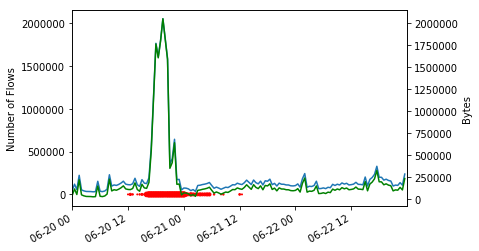

In [101]:
# plot raw agg stats
fig, ax = plt.subplots(1)
ax.plot(df_agg['time'], df_agg['Flows'])
ax.scatter(X_spam, Y_spam, size_spam, color='red')
ax.set_xlim(xmin=pd.to_datetime("2016-06-20 00:00:00"), 
            xmax=pd.to_datetime("2016-06-22 23:59:00"))
ax.set_ylabel("Number of Flows")

ax2 = ax.twinx()
ax2.plot(df_agg['time'], df_agg['Flows'], color = "green")
ax2.set_ylabel("Bytes")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d %H:%S')

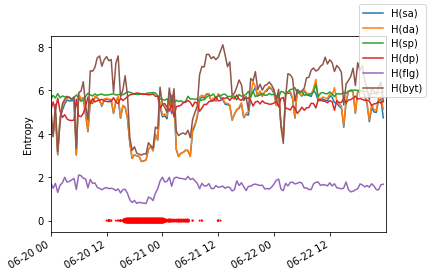

In [207]:
# plot entropy values
fig, ax = plt.subplots(1)
ax.plot(df_agg['time'], df_agg[["H(sa)", "H(da)", "H(sp)", "H(dp)", "H(flg)", "H(byt)"]])
# ax.scatter(X, Y, S, color='red')
ax.scatter(X_spam, Y_spam, size_spam, color='red')

ax.set_xlim(xmin=pd.to_datetime("2016-06-20 00:00:00"), 
            xmax=pd.to_datetime("2016-06-22 23:59:00"))
ax.set_ylabel("Entropy")

fig.autofmt_xdate()
labels = ["H(sa)", "H(da)", "H(sp)", "H(dp)", "H(flg)", "H(byt)"]
fig.legend(labels)
ax.fmt_xdata = mdates.DateFormatter('%m-%d %H:%S')

## OCSVM

In [422]:
# label data
data = pd.merge(df_agg, df_anom, how='left')
# data.rename(columns={'anomaly-spam':'label'}, inplace=True)

# class 1 (normal) and class -1 (attack)
data.loc[data['anomaly-spam'] == 0, "attack"] = 1  
data.loc[data['anomaly-spam'] > 0, "attack"] = -1

# cheat by making spam super extreme
# data.loc[data['attack']==-1, 'H(sa)'] = 10
# data.loc[data['attack']==-1, 'H(da)'] = 10

In [423]:
# relevant_features = ["H(sa)", "H(da)", "H(sp)", "H(dp)", "H(flg)", "H(byt)", "Flows", "Bytes"] 
# relevant_features = ["H(sa)", "H(da)", "H(sp)", "H(dp)", "H(flg)", "H(byt)"] 
relevant_features = ["H(sa)", "H(da)"] 

relevant_columns = relevant_features + ["attack"]

data = data[relevant_columns]

# normalize
# for feat in relevant_features:
#     data[feat] = np.log((data[feat] + 0.1).astype(float))

In [424]:
data.head()

,H(sa),H(da),attack
0,4.786381,4.849955,1.0
1,3.864454,3.917633,1.0
2,4.833561,4.919651,1.0
3,3.027618,3.058674,1.0
4,4.701964,4.778389,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f060e560a58>,
      dtype=object)

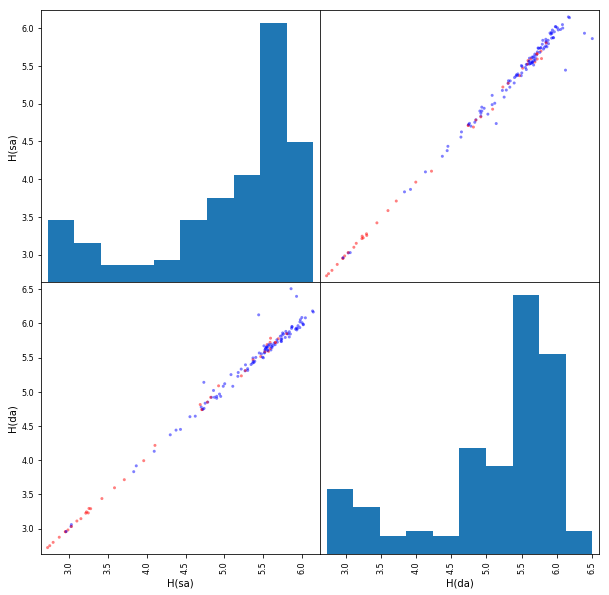

In [425]:
# visualize the data
from pandas.plotting import scatter_matrix
colors = np.where(data['attack']==1,'b','r')
scatter_matrix(data[relevant_features], c=colors, figsize=(10,10))

In [426]:
target = data['attack']
outliers = target[target == -1]
print("outliers.shape", outliers.shape)
print("outliers fraction", outliers.shape[0]/target.shape[0])

outliers.shape (40,)
outliers fraction 0.2777777777777778


In [415]:
# drop label and attack for unsupervised learning
data.drop(['attack'], axis = 1, inplace=True)
data.shape

(144, 2)

In [416]:
# split data into training and test sets
from sklearn.model_selection import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  

/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(115, 2)

In [417]:
from sklearn import svm

nu = outliers.shape[0] / target.shape[0]
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=0.0001)

model.fit(train_data)

nu 0.2777777777777778


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
      max_iter=-1, nu=0.2777777777777778, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [418]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  0.782608695652174
precision:  0.8589743589743589
recall:  0.8271604938271605
f1:  0.8427672955974842
area under curve (auc):  0.7518155410312274


In [419]:
preds = model.predict(test_data)  
targs = test_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  0.6551724137931034
precision:  0.8823529411764706
recall:  0.6521739130434783
f1:  0.75
area under curve (auc):  0.6594202898550726


In [420]:
# try with 2 class SVM
model_svm = svm.SVC()
model_svm.fit(train_data, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [421]:
preds = model_svm.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
area under curve (auc):  1.0


In [409]:
preds = model_svm.predict(test_data)  
targs = test_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
area under curve (auc):  1.0
